In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from yahoofinancials import YahooFinancials

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
data=data.drop('Volume',1)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_79087/271620078.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop('Volume',1)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2019-01-02,25824.439453,25824.439453,25055.269531,25130.349609,25130.349609,25064.359375
2019-01-03,25077.679688,25262.210938,24896.869141,25064.359375,25064.359375,25626.029297
2019-01-04,24946.119141,25626.029297,24924.730469,25626.029297,25626.029297,25835.699219
2019-01-07,26015.839844,26043.640625,25753.460938,25835.699219,25835.699219,25875.449219
2019-01-08,25852.500000,25960.890625,25688.500000,25875.449219,25875.449219,26462.320312
...,...,...,...,...,...,...
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.539062


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_79087/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


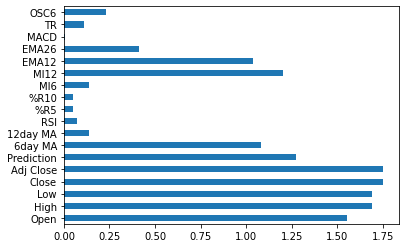

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_79087/2479088833.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


In [6]:
data_val=data[-100:]
data=data[:-100]

In [7]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(484, 1, 10) (484,) (122, 1, 10) (122,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_79087/1866109569.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 16:06:07.068986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 16:06:07.069100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 16:06:07.479412: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 16:06:08.683129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:08.884310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:08.925804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:09.000015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:09.064945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 32ms/step - loss: 698591104.0000 - val_loss: 764431424.0000
Epoch 2/500
 1/28 [>.............................] - ETA: 0s - loss: 829478272.0000

2022-04-12 16:06:09.817655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:09.889440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:06:09.912713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 10ms/step - loss: 698538880.0000 - val_loss: 764251840.0000
Epoch 3/500
28/28 [==============================] - 0s 10ms/step - loss: 698274304.0000 - val_loss: 763115264.0000
Epoch 4/500
28/28 [==============================] - 0s 10ms/step - loss: 696996224.0000 - val_loss: 759687872.0000
Epoch 5/500
28/28 [==============================] - 0s 10ms/step - loss: 693488768.0000 - val_loss: 754399104.0000
Epoch 6/500
28/28 [==============================] - 0s 10ms/step - loss: 687616000.0000 - val_loss: 747999360.0000
Epoch 7/500
28/28 [==============================] - 0s 10ms/step - loss: 680700992.0000 - val_loss: 740924224.0000
Epoch 8/500
28/28 [==============================] - 0s 10ms/step - loss: 673469696.0000 - val_loss: 733380288.0000
Epoch 9/500
28/28 [==============================] - 0s 10ms/step - loss: 665920000.0000 - val_loss: 725387264.0000
Epoch 10/500
28/28 [==============================] - 0s 9ms/step - loss: 657995968.

28/28 [==============================] - 0s 10ms/step - loss: 3529093.2500 - val_loss: 3169445.2500
Epoch 145/500
28/28 [==============================] - 0s 10ms/step - loss: 3529100.0000 - val_loss: 3168699.0000
Epoch 146/500
28/28 [==============================] - 0s 10ms/step - loss: 3528974.0000 - val_loss: 3168089.0000
Epoch 147/500
28/28 [==============================] - 0s 10ms/step - loss: 3528593.2500 - val_loss: 3167579.7500
Epoch 148/500
28/28 [==============================] - 0s 10ms/step - loss: 3527675.2500 - val_loss: 3167119.5000
Epoch 149/500
28/28 [==============================] - 0s 11ms/step - loss: 3525350.5000 - val_loss: 3166612.2500
Epoch 150/500
28/28 [==============================] - 0s 10ms/step - loss: 3517538.7500 - val_loss: 3165749.7500
Epoch 151/500
28/28 [==============================] - 0s 10ms/step - loss: 3447642.2500 - val_loss: 3161706.7500
Epoch 152/500
28/28 [==============================] - 0s 10ms/step - loss: 2399851.5000 - val_loss: 3

Epoch 217/500
28/28 [==============================] - 0s 11ms/step - loss: 188461.0938 - val_loss: 241784.5312
Epoch 218/500
28/28 [==============================] - 0s 11ms/step - loss: 185364.6719 - val_loss: 237175.6406
Epoch 219/500
28/28 [==============================] - 0s 10ms/step - loss: 182403.3906 - val_loss: 232773.6406
Epoch 220/500
28/28 [==============================] - 0s 10ms/step - loss: 179573.8438 - val_loss: 228572.9688
Epoch 221/500
28/28 [==============================] - 0s 12ms/step - loss: 176874.5781 - val_loss: 224561.5312
Epoch 222/500
28/28 [==============================] - 0s 11ms/step - loss: 174301.7344 - val_loss: 220732.5469
Epoch 223/500
28/28 [==============================] - 0s 12ms/step - loss: 171853.3125 - val_loss: 217081.4062
Epoch 224/500
28/28 [==============================] - 0s 10ms/step - loss: 169527.2031 - val_loss: 213592.0781
Epoch 225/500
28/28 [==============================] - 0s 10ms/step - loss: 167317.5469 - val_loss: 2102

28/28 [==============================] - 0s 9ms/step - loss: 110908.0703 - val_loss: 139040.2969
Epoch 364/500
28/28 [==============================] - 0s 10ms/step - loss: 111022.8750 - val_loss: 139573.4062
Epoch 365/500
28/28 [==============================] - 0s 11ms/step - loss: 111130.8281 - val_loss: 140168.2188
Epoch 366/500
28/28 [==============================] - 0s 9ms/step - loss: 111206.2812 - val_loss: 140798.4219
Epoch 367/500
28/28 [==============================] - 0s 9ms/step - loss: 111250.7500 - val_loss: 141377.5000
Epoch 368/500
28/28 [==============================] - 0s 9ms/step - loss: 111274.9688 - val_loss: 141843.1875
Epoch 369/500
28/28 [==============================] - 0s 9ms/step - loss: 111282.1484 - val_loss: 142193.0625
Epoch 370/500
28/28 [==============================] - 0s 9ms/step - loss: 111268.8672 - val_loss: 142457.6250
Epoch 371/500
28/28 [==============================] - 0s 9ms/step - loss: 111234.9766 - val_loss: 142662.2656
Epoch 372/500

Epoch 437/500
28/28 [==============================] - 0s 9ms/step - loss: 109861.8828 - val_loss: 151192.8438
Epoch 438/500
28/28 [==============================] - 0s 10ms/step - loss: 109767.5156 - val_loss: 150796.0312
Epoch 439/500
28/28 [==============================] - 0s 9ms/step - loss: 109664.8828 - val_loss: 150354.0156
Epoch 440/500
28/28 [==============================] - 0s 9ms/step - loss: 109558.8125 - val_loss: 149896.1562
Epoch 441/500
28/28 [==============================] - 0s 9ms/step - loss: 109454.6562 - val_loss: 149453.4062
Epoch 442/500
28/28 [==============================] - 0s 9ms/step - loss: 109357.6641 - val_loss: 149055.3594
Epoch 443/500
28/28 [==============================] - 0s 10ms/step - loss: 109272.5703 - val_loss: 148727.8750
Epoch 444/500
28/28 [==============================] - 0s 11ms/step - loss: 109202.8125 - val_loss: 148492.3594
Epoch 445/500
28/28 [==============================] - 0s 9ms/step - loss: 109151.3750 - val_loss: 148364.359

2022-04-12 16:08:28.714070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:08:28.783742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 16:08:28.826101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


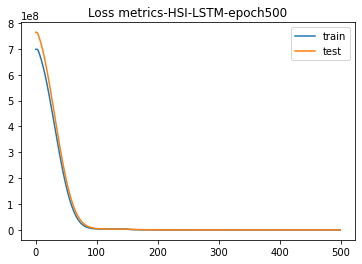

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.title('Loss metrics-HSI-LSTM-epoch500')
plt.legend()

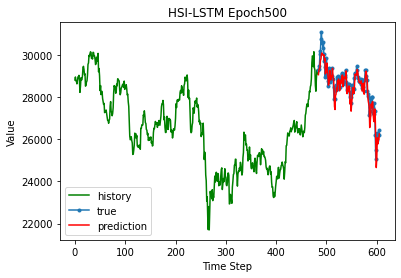

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM Epoch500')
plt.legend()
plt.show()

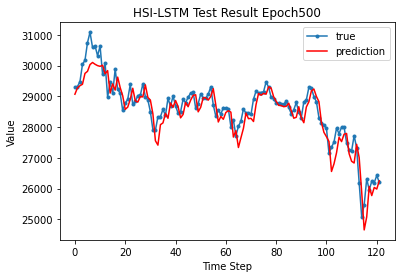

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM Test Result Epoch500')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.8245894753015652

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.011956269250773805

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

428.7185318437449

In [17]:
x_val=data_val.drop('Prediction',1).values
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_79087/264374676.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


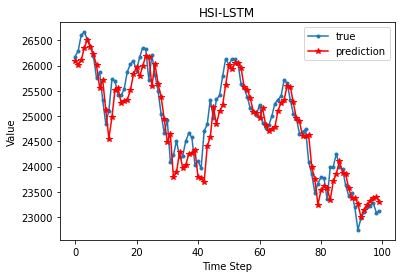

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.8881800989472896

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.010926044240299837

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

334.8423004958642